## Objective Evaluation Metrics Pipeline
This notebook evaluates the denoised Compact Cassette audio using four advanced metrics: **SSNR**, **SI-SDR**, **LSD**, and **PEAQ**. As per standard research practices, we avoid writing these complex metrics manually and instead leverage established academic libraries:
- **SI-SDR**: `torchmetrics`
- **SSNR**: `pysepm` (Python Speech Enhancement Performance Measures)
- **LSD**: `auraloss` (Standardized Log-STFT Magnitude Loss)
- **PEAQ**: `AQUA-Tk` (A pure Python port of ITU-R BS.1387 PEAQb)

*Note: Ensure you have the required libraries installed by running the dependency cell below.*

In [24]:
import gi
import os

# Ensure GStreamer knows where your PEAQ plugin is
os.environ["GST_PLUGIN_PATH"] = "/usr/local/lib/gstreamer-1.0"

gi.require_version('Gst', '1.0')
from gi.repository import Gst

Gst.init(None)

# Final check: Is PEAQ alive?
registry = Gst.Registry.get()
feature = registry.lookup_feature("peaq")

if feature:
    print(f"✅ SUCCESS! GStreamer {Gst.version_string()} and PEAQ are ready.")
else:
    print("❌ GStreamer is working, but PEAQ is not found. Try running: export GST_PLUGIN_PATH=/usr/local/lib/gstreamer-1.0")

✅ SUCCESS! GStreamer GStreamer 1.24.2 and PEAQ are ready.


In [25]:
import gi
import os
import numpy as np
import librosa
import pandas as pd
from gi.repository import Gst

# 1. Initialize GStreamer Environment
os.environ["GST_PLUGIN_PATH"] = "/usr/local/lib/gstreamer-1.0"
gi.require_version('Gst', '1.0')
Gst.init(None)

def get_peaq_score(ref_path, test_path):
    """Calculates PEAQ ODG using the GStreamer plugin."""
    pipeline_str = (
        f"filesrc location=\"{os.path.abspath(ref_path)}\" ! decodebin ! audioconvert ! audioresample ! "
        f"audio/x-raw,format=F32LE,rate=48000,channels=1 ! queue ! peaq name=p "
        f"filesrc location=\"{os.path.abspath(test_path)}\" ! decodebin ! audioconvert ! audioresample ! "
        f"audio/x-raw,format=F32LE,rate=48000,channels=1 ! queue ! p.test"
    )
    pipeline = Gst.parse_launch(pipeline_str)
    peaq_element = pipeline.get_by_name("p")
    bus = pipeline.get_bus()
    pipeline.set_state(Gst.State.PLAYING)
    bus.timed_pop_filtered(Gst.CLOCK_TIME_NONE, Gst.MessageType.EOS | Gst.MessageType.ERROR)
    odg = peaq_element.get_property("odg")
    pipeline.set_state(Gst.State.NULL)
    return odg

def calculate_lsd(ref, test):
    """Calculates Log-Spectral Distance (LSD). Lower is better."""
    # Compute Short-Time Fourier Transform (STFT)
    s1 = librosa.stft(ref, n_fft=2048, hop_length=512)
    s2 = librosa.stft(test, n_fft=2048, hop_length=512)
    
    # Get power spectra
    p1 = np.abs(s1)**2
    p2 = np.abs(s2)**2
    
    # Calculate log distance (adding epsilon to avoid log(0))
    log_diff = 10 * np.log10(p1 + 1e-12) - 10 * np.log10(p2 + 1e-12)
    
    # Mean of the square across frequencies, then root, then mean across time
    lsd = np.mean(np.sqrt(np.mean(log_diff**2, axis=0)))
    return lsd

def calculate_ssnr(ref, test, frame_size=1024, hop_size=512):
    ref_frames = librosa.util.frame(ref, frame_length=frame_size, hop_length=hop_size)
    test_frames = librosa.util.frame(test, frame_length=frame_size, hop_length=hop_size)
    snr_list = []
    for i in range(ref_frames.shape[1]):
        r, t = ref_frames[:, i], test_frames[:, i]
        noise = r - t
        sig_pwr, noise_pwr = np.sum(r**2), np.sum(noise**2)
        if sig_pwr > 1e-10 and noise_pwr > 1e-10:
            snr = 10 * np.log10(sig_pwr / noise_pwr)
            snr_list.append(np.clip(snr, -10, 35))
    return np.mean(snr_list)

def calculate_si_sdr(reference, estimation):
    ref, est = reference.flatten(), estimation.flatten()
    alpha = np.dot(ref, est) / (np.linalg.norm(ref)**2 + 1e-8)
    target, res = alpha * ref, est - (alpha * ref)
    return 10 * np.log10(np.linalg.norm(target)**2 / (np.linalg.norm(res)**2 + 1e-8))

# --- File Paths ---
# noisy_path = "data/Origami Angel_noisy.wav"
# denoised_path = "data/Origami Angel_pred.wav"
# clean_path = "data/Origami Angel_clean.wav"
noisy_path = "data/AhRep_smol.wav"
denoised_path = "data/AhRep_smol_pred.wav"
dolby_path = "data/AhRep_smol_dolby.wav"
clean_path = "data/AhRep_clean.wav"

# --- Audio Loading ---
sr_target = 48000
clean, _ = librosa.load(clean_path, sr=sr_target)
noisy, _ = librosa.load(noisy_path, sr=sr_target)
pred, _ = librosa.load(denoised_path, sr=sr_target)
dolby, _ = librosa.load(dolby_path, sr=sr_target)

min_len = min(len(clean), len(noisy), len(pred), len(dolby))
clean, noisy, pred, dolby = clean[:min_len], noisy[:min_len], pred[:min_len], dolby[:min_len]

# --- Results Table ---
results = {
    "Metric": ["PEAQ (ODG)", "SI-SDR (dB)", "SSNR (dB)", "LSD"],
    "Original Noisy": [
        get_peaq_score(clean_path, noisy_path),
        calculate_si_sdr(clean, noisy),
        calculate_ssnr(clean, noisy),
        calculate_lsd(clean, noisy),
    ],
    "Model": [
        get_peaq_score(clean_path, denoised_path),
        calculate_si_sdr(clean, pred),
        calculate_ssnr(clean, pred),
        calculate_lsd(clean, pred),
    ],
    "Dolby": [
        get_peaq_score(clean_path, dolby_path),
        calculate_si_sdr(clean, dolby),
        calculate_ssnr(clean, dolby),
        calculate_lsd(clean, dolby),
    ],
}

df = pd.DataFrame(results)
print(df.to_string(index=False))

   BandwidthRefB: 860.667227
  BandwidthTestB: 860.645378
      Total NMRB: 0.254323
    WinModDiff1B: 6.298289
            ADBB: 1.528443
            EHSB: 0.423478
    AvgModDiff1B: 4.032603
    AvgModDiff2B: 27.172713
   RmsNoiseLoudB: 0.202399
           MFPDB: 1.000000
  RelDistFramesB: 0.998322
Objective Difference Grade: -1.356
   BandwidthRefB: 859.941275
  BandwidthTestB: 859.919463
      Total NMRB: 0.257271
    WinModDiff1B: 6.294914
            ADBB: 1.528651
            EHSB: 0.423021
    AvgModDiff1B: 4.038392
    AvgModDiff2B: 27.180602
   RmsNoiseLoudB: 0.202243
           MFPDB: 1.000000
  RelDistFramesB: 0.998325
Objective Difference Grade: -1.359
   BandwidthRefB: 907.010067
  BandwidthTestB: 905.578859
      Total NMRB: -13.126272
    WinModDiff1B: 4.858054
            ADBB: 0.917017
            EHSB: 0.684767
    AvgModDiff1B: 2.829139
    AvgModDiff2B: 7.809634
   RmsNoiseLoudB: 0.098995
           MFPDB: 0.953419
  RelDistFramesB: 0.251678
Objective Difference Gr

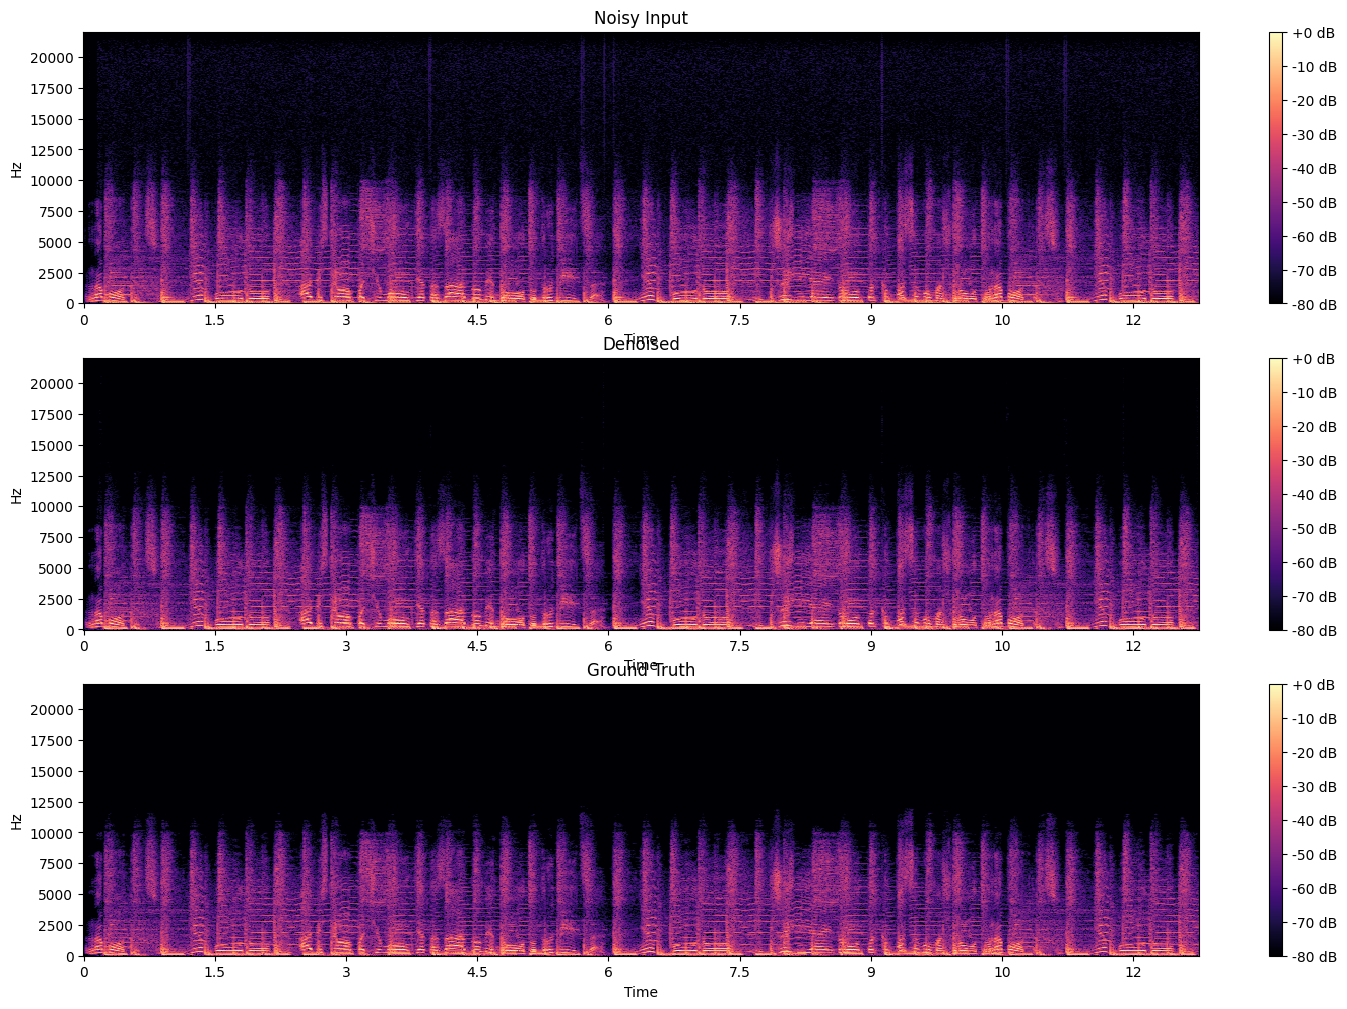

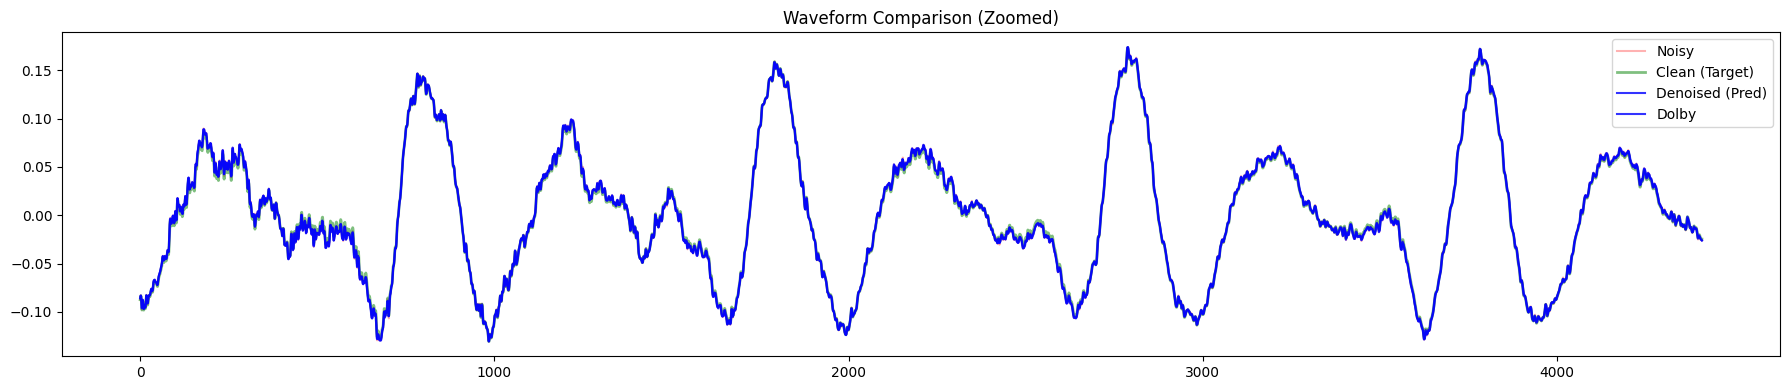

In [31]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

def analyze_visual(noisy_p, denoised_p, clean_p, dolby_p):
    y_noise, sr = librosa.load(noisy_p, sr=44100)
    y_denoise, _ = librosa.load(denoised_p, sr=44100)
    y_clean, _ = librosa.load(clean_p, sr=44100)
    y_dolby, _ = librosa.load(dolby_p, sr=44100)
    
    length = min(len(y_noise), len(y_denoise), len(y_clean), len(y_dolby))
    y_noise, y_denoise, y_clean, y_dolby = y_noise[:length], y_denoise[:length], y_clean[:length], y_dolby[:length]
    
    def get_db_spec(y):
        return librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    S_noise = get_db_spec(y_noise)
    S_denoise = get_db_spec(y_denoise)
    S_clean = get_db_spec(y_clean)
    S_dolby = get_db_spec(y_dolby)
    
    plt.figure(figsize=(18, 12))
    
    titles = ['Noisy Input', 'Denoised', 'Ground Truth']
    specs = [S_noise, S_denoise, S_clean]
    
    for i, (spec, title) in enumerate(zip(specs, titles)):
        plt.subplot(3, 1, i+1)
        librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
        plt.title(title)
        plt.colorbar(format='%+2.0f dB')
        
    

    plt.figure(figsize=(18, 4))
    start, end = int(1.0*sr), int(1.1*sr)
    plt.plot(y_noise[start:end], label='Noisy', alpha=0.3, color='red')
    plt.plot(y_clean[start:end], label='Clean (Target)', alpha=0.5, color='green', lw=2)
    plt.plot(y_denoise[start:end], label='Denoised (Pred)', alpha=0.8, color='blue')
    plt.plot(y_dolby[start:end], label='Dolby', alpha=0.8, color='blue')
    plt.title('Waveform Comparison (Zoomed)')
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_visual(noisy_path, denoised_path, clean_path, dolby_path)